# RNN FINAL

Epoch 1/10 - Train Loss: 0.6875, Val Accuracy: 0.5582
Epoch 2/10 - Train Loss: 0.6662, Val Accuracy: 0.5644
Epoch 3/10 - Train Loss: 0.6693, Val Accuracy: 0.5887
Epoch 4/10 - Train Loss: 0.6356, Val Accuracy: 0.6744
Epoch 5/10 - Train Loss: 0.5993, Val Accuracy: 0.5249
Epoch 6/10 - Train Loss: 0.6891, Val Accuracy: 0.5161
Epoch 7/10 - Train Loss: 0.6479, Val Accuracy: 0.5775
Epoch 8/10 - Train Loss: 0.6280, Val Accuracy: 0.6959
Epoch 9/10 - Train Loss: 0.5517, Val Accuracy: 0.7312
Epoch 10/10 - Train Loss: 0.5434, Val Accuracy: 0.5794


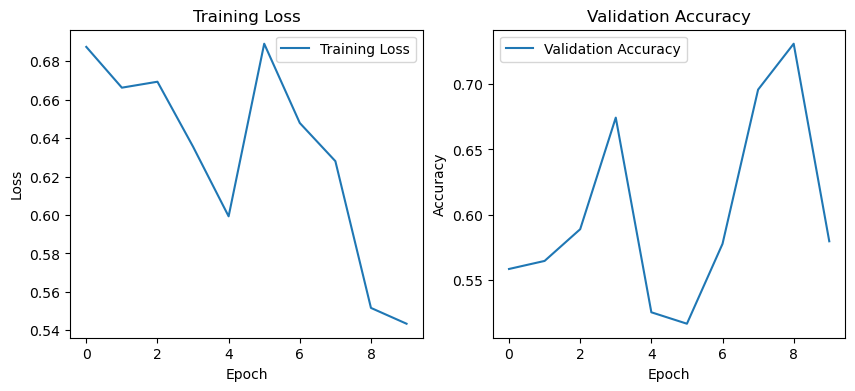

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# Load and preprocess the dataset
file_path = r"D:\ShaluPersonal_DataSc\MSCDS_3Sem\project\FakeReviewDataset.csv"
df = pd.read_csv(file_path)
df['label'] = df['label'].apply(lambda x: 1 if x == 'CG' else 0)

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Tokenize texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create DataLoaders
train_dataset = TensorDataset(train_encodings['input_ids'], torch.tensor(train_labels.values))
val_dataset = TensorDataset(val_encodings['input_ids'], torch.tensor(val_labels.values))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Define a simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        return self.fc(h_n.squeeze(0))

# Model setup
vocab_size = tokenizer.vocab_size
embed_size = 64
hidden_size = 32
num_classes = 2
model = SimpleRNN(vocab_size, embed_size, hidden_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training and validation
epochs = 10
train_losses, val_accuracies = [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plot Loss and Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [4]:
import pickle

# Save the entire model using pickle
with open("rnn_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as 'rnn_model.pkl'")

Model saved as 'rnn_model.pkl'
